In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from utils import metrics
from utils import randomg

[  1.           1.           0.           0.           2.71111111
 122.        ]


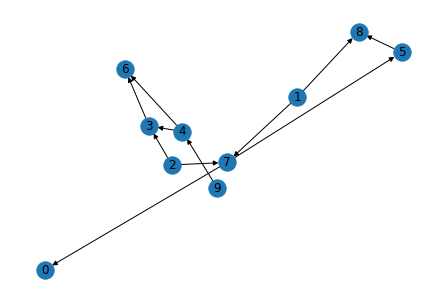

In [2]:
# test single
G=randomg.generate_random_graph(10)
nx.draw_spring(G, with_labels = True)
m=metrics.compute_metrics(G)
print(m)

### comparison to db and rl

In [2]:
n_waters = 10
generate_random = False

In [3]:
# load db
db = pd.read_pickle(f'data/W{n_waters}_cluster_graphs.pkl.gz')
db=db[['trimers', 'tetramers', 'pentamers', 'hexamers', 'shortest_path', 'wiener']]
db['class']='db'
db.head()

,trimers,tetramers,pentamers,hexamers,shortest_path,wiener,class
0,0,5,2,0,1.888889,170.0,db
1,0,5,2,0,1.888889,170.0,db
2,0,5,2,0,1.888889,170.0,db
3,0,5,2,0,1.888889,170.0,db
4,0,5,2,0,1.888889,170.0,db


In [4]:
# generate sample

if generate_random:
    df = randomg.generate_random_sample(n_waters, n=95820) #len(db))
    df['class']='random'
    df.to_csv(f'data/W{n_waters}_random_graph_metrics.csv', index=False)
else:
    df = pd.read_csv(f'data/W{n_waters}_random_graph_metrics.csv')
df.head()

,trimers,tetramers,pentamers,hexamers,shortest_path,wiener,class
0,1.0,0.0,0.0,1.0,2.377778,107.0,random
1,1.0,0.0,0.0,0.0,3.044444,137.0,random
2,1.0,0.0,1.0,0.0,2.333333,105.0,random
3,0.0,0.0,1.0,0.0,2.622222,118.0,random
4,2.0,1.0,0.0,1.0,2.155556,97.0,random


In [94]:
## load rl

drl =  pd.read_pickle('outputs/rl_outputs.pkl')

def get_metrics_from_df(df, n_waters, column='graph'):
    labels=['trimers','tetramers','pentamers','hexamers','shortest_path','wiener']
    df = df.loc[df['size']==10]
    data=np.vstack([metrics.compute_metrics(df.iloc[i][column]) for i in range(len(df))]).T

    df_metrics=pd.DataFrame({labels[i]:data[i] for i in range(len(labels))})

    return df_metrics

dr = get_metrics_from_df(drl, n_waters, column='graph')
dr['class']='rl'
dr.head()

,trimers,tetramers,pentamers,hexamers,shortest_path,wiener,class
0,0.0,0.0,0.0,0.0,3.666667,165.0,rl-random
1,0.0,0.0,0.0,0.0,3.666667,165.0,rl-random
2,0.0,0.0,0.0,0.0,3.666667,165.0,rl-random
3,0.0,0.0,0.0,0.0,3.666667,165.0,rl-random
4,0.0,0.0,0.0,0.0,3.666667,165.0,rl-random


In [5]:
# join

dd = pd.concat([df,db], ignore_index=True)
dd.to_csv(f'data/W{n_waters}_metric_comparison.csv', index=False)
dd.head()

,trimers,tetramers,pentamers,hexamers,shortest_path,wiener,class
0,1.0,0.0,0.0,1.0,2.377778,107.0,random
1,1.0,0.0,0.0,0.0,3.044444,137.0,random
2,1.0,0.0,1.0,0.0,2.333333,105.0,random
3,0.0,0.0,1.0,0.0,2.622222,118.0,random
4,2.0,1.0,0.0,1.0,2.155556,97.0,random


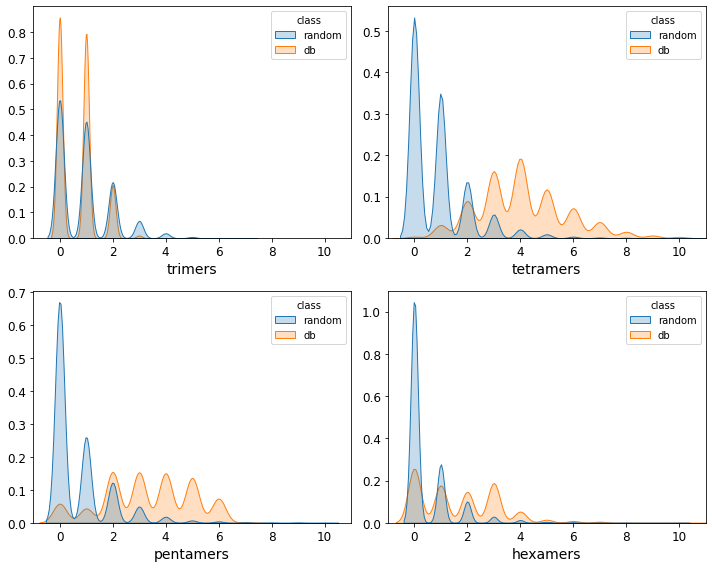

In [6]:
fig,(axt,axb)=plt.subplots(2, 2, figsize=(10,8))

for i,ax in enumerate([axt[0],axt[1],axb[0],axb[1]]):
    sns.kdeplot(data=dd.loc[dd.shortest_path>0], x=dd.columns[i], hue='class', fill=True, ax=ax)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.set_ylabel('')
    ax.set_xlabel(dd.columns[i], fontsize=14)
    ax.set_xlim(-1,11)
    
    if len(dd.loc[(dd.shortest_path>0)&(dd['class']=='rl')])>0:
        #sns.countplot(data=dd.loc[(dd.shortest_path>0)&(dd['class']=='rl')], x=dd.columns[i], ax=ax,  color='black', alpha=0.1)
        x=dd.loc[(dd.shortest_path>0)&(dd['class']=='rl')][dd.columns[i]].value_counts(normalize=True).index
        y=dd.loc[(dd.shortest_path>0)&(dd['class']=='rl')][dd.columns[i]].value_counts(normalize=True).values
        ax.bar(x=x, height=y,  color='#CAE7CA', alpha=0.8, width= 0.2, edgecolor='#47AC47', linewidth=1.2)
    
plt.tight_layout()
plt.show()

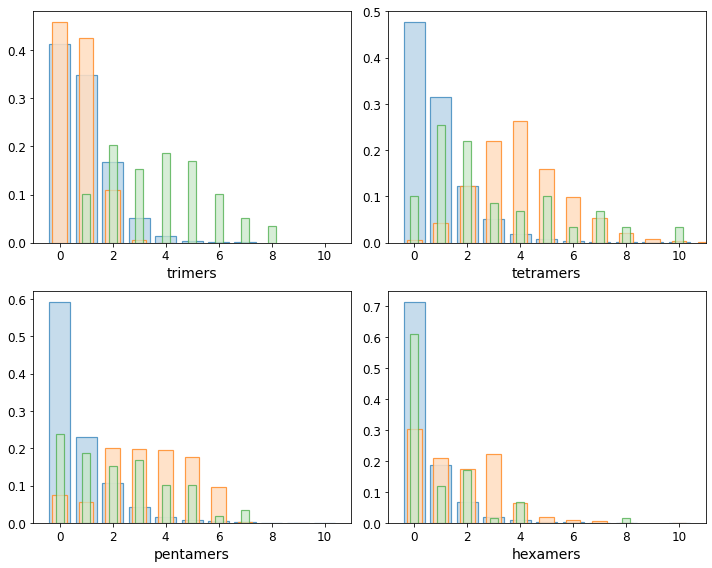

In [90]:
fig,(axt,axb)=plt.subplots(2, 2, figsize=(10,8))

for i,ax in enumerate([axt[0],axt[1],axb[0],axb[1]]):
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.set_ylabel('')
    ax.set_xlabel(dd.columns[i], fontsize=14)
    ax.set_xlim(-1,11)
    
    
    inside_color=['#C6DCEC','#FFDEC2','#CAE7CA']
    edge_color=['#599AC7','#FF8F2D','#47AC47']
    
    for l,lab in enumerate(['random', 'db', 'rl']):
        x=dd.loc[(dd.shortest_path>0)&(dd['class']==lab)][dd.columns[i]].value_counts(normalize=True).index
        y=dd.loc[(dd.shortest_path>0)&(dd['class']==lab)][dd.columns[i]].value_counts(normalize=True).values

        ax.bar(x=x, height=y,  color=inside_color[l], alpha=1-(l/8), width= 0.8-(l/4), 
               edgecolor=edge_color[l], linewidth=1.2, label=lab)
    
plt.tight_layout()
plt.show()

In [11]:
def generate_with_constraints(n_waters, bidirectional=False):
    '''
    constraints: 
        edges: max 2 in; max 2 out; no self loops; no edges go in both directions
    '''
    
    # set random in and out degrees, 2 max for each
    in_degrees = np.random.randint(0, high=3, size=n_waters)
    out_degrees = np.random.randint(0, high=3, size=n_waters)

    # check for and fix disconnected water molecules
    for n in range(n_waters):
        while (in_degrees[n]==0) and (out_degrees[n]==0):
            in_degrees[n]=np.random.randint(0, high=3, size=1)
            out_degrees[n]=np.random.randint(0, high=3, size=1)
            #print(f'reconnected water {n}')


    # sum of in and out degrees must be equal
    # make list same length by adding to lowest to get highest
    if in_degrees.sum() != out_degrees.sum():
        to_add = np.abs(in_degrees.sum() - out_degrees.sum())

        if in_degrees.sum() < out_degrees.sum():
            # add to random spots to 
            # get indices < 2
            idxes = np.concatenate((np.where(in_degrees<2)[0],np.where(in_degrees<1)[0]))
            for i in np.random.choice(idxes, size=to_add, replace=False):
                in_degrees[i]+=1
        elif in_degrees.sum() > out_degrees.sum():
            idxes = np.concatenate((np.where(out_degrees<2)[0],np.where(out_degrees<1)[0]))
            for i in np.random.choice(idxes, size=to_add, replace=False):
                out_degrees[i]+=1

    G = nx.directed_configuration_model(in_degrees, out_degrees, create_using=nx.DiGraph)

    # no self loops
    G.remove_edges_from(nx.selfloop_edges(G))
    
    # remove edges that go in both directions
    for edge in G.to_undirected(reciprocal=True).edges:
        edge = list(edge)
        np.random.shuffle(edge)
        G.remove_edge(edge[0],edge[1])
        #print(f'removed edge {edge[0],edge[1]}')

    # add node and edge attributes
    nx.set_node_attributes(G, 'O', "label")
    nx.set_edge_attributes(G, 'donate', "label")
        
    if bidirectional:
        # Assign bonds to each water molecule
        for edge in G.edges():
            # Add the edges
            G.add_edge(edge[1], edge[0], label='accept')


    return G

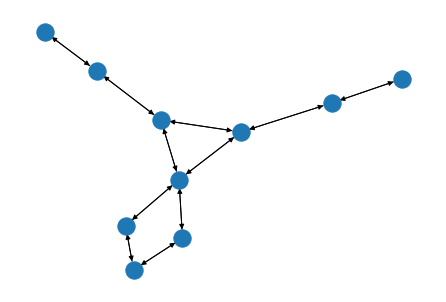

In [13]:
G=generate_with_constraints(10, bidirectional=True)
nx.draw_spring(G)

In [14]:
G.edges

OutEdgeView([(0, 8), (1, 4), (1, 3), (2, 9), (2, 8), (2, 3), (3, 2), (3, 5), (3, 1), (3, 9), (4, 5), (4, 1), (5, 3), (5, 4), (6, 7), (6, 9), (7, 6), (8, 0), (8, 2), (9, 6), (9, 3), (9, 2)])